In [ ]:
%cd '/content/drive/MyDrive/ColabNotebooks/TSGANs/TimeGAN_TF2'

/content/drive/MyDrive/ColabNotebooks/TSGANs/TimeGAN_TF2


## Imports

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from matplotlib.ticker import FuncFormatter

from pathlib import Path

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from tensorflow.keras.metrics import AUC
from tensorflow.keras.layers import (GRU, Dense) 
                                     
import os, time
import pandas as pd
import numpy as np
#import tensorflow as tf

import matplotlib.pyplot as plt 
import seaborn as sns

sns.set_style('white')

# Unnecessary

In [ ]:
!pip3 install --upgrade tables
!pip3 install keras-tcn --no-dependencies

In [ ]:
from tcn_timegan.src.tcn_ae import TCN_AE

# Parameters

In [ ]:
from tcn_timegan.src.params_09 import (experiment, 
                                      ## Data Parameters
                                      data_file,
                                      ts_names,
                                      start_date,
                                      end_date,
                                      data_name,
                                      synthetic_data_name,
                                       
                                      ## Training Parameters
                                      n_seq,
                                      seq_len)                                       

# Experiment Path

In [ ]:
results_path = Path('./tcn_timegan')
if not results_path.exists():
    results_path.mkdir()

In [ ]:
log_dir = results_path / f'experiment_{experiment:02}'
if not log_dir.exists():
    log_dir.mkdir(parents=True)

In [ ]:
sample_dir = log_dir / 'samples'
if not sample_dir.exists():
    sample_dir.mkdir(parents=True)

In [ ]:
evals_dir = log_dir / 'evals'
if not evals_dir.exists():
    evals_dir.mkdir(parents=True)

In [ ]:
hdf_store = log_dir / f'TimeSeriesGAN_{experiment:02}.h5'

# Load Real and Synthetic Data

## Load Real Data

In [ ]:
tickers = ts_names

In [ ]:
df = pd.read_hdf(hdf_store, 'data/real')
df = df.set_index(['date'])     # use DateTime index

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 512 entries, 1895Q1 to 2022Q4
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PDSI    512 non-null    float64
 1   PHDI    512 non-null    float64
 2   PMDI    512 non-null    float64
 3   PZI     512 non-null    float64
dtypes: float64(4)
memory usage: 20.0+ KB


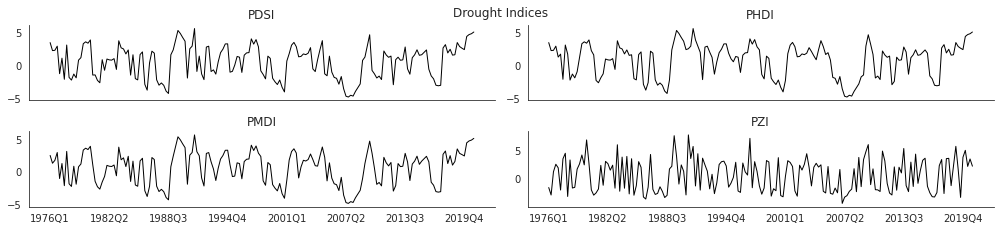

In [ ]:
axes = df.loc[start_date:end_date].plot(subplots=True,
                                        figsize=(14, 6),
                                        layout=(n_seq, 2),
                                        title=tickers,
                                        legend=False,
                                        rot=0,
                                        lw=1, 
                                        color='k')
for ax in axes.flatten():
    ax.set_xlabel('')

plt.suptitle('Drought Indices')
plt.gcf().tight_layout()
sns.despine();

## Normalize Real Data

In [ ]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df).astype(np.float32)

## Create rolling window sequences

In [ ]:
data = []
for i in range(len(df)-seq_len): 
  data.append(scaled_data[i:i + seq_len])

real_data = np.stack(data)
real_dat.shape

(332, 180, 4)

## Load Synthetic Data

In [ ]:
synthetic_data = np.load(results_path / f'experiment_{experiment:02d}' / 'generated_data.npy')
synthetic_data.shape

(512, 180, 4)

# Prepare Sample

In [ ]:
sample_size = 250
idx = np.random.permutation(len(real_data))[:sample_size]

In [ ]:
# Data preprocessing
real_sample = np.asarray(real_data)[idx]
synthetic_sample = np.asarray(synthetic_data)[idx]

In [ ]:
real_sample_2d = real_sample.reshape(-1, seq_len)
synthetic_sample_2d = synthetic_sample.reshape(-1, seq_len)

In [ ]:
real_sample_2d.shape, synthetic_sample_2d.shape

((1000, 180), (1000, 180))

# Visualization in 2D: A Qualitative Assessment of Diversity

## Run PCA

In [ ]:
pca = PCA(n_components=2)
pca.fit(real_sample_2d)
pca_real = (pd.DataFrame(pca.transform(real_sample_2d))
            .assign(Data='Real'))
pca_synthetic = (pd.DataFrame(pca.transform(synthetic_sample_2d))
                 .assign(Data='Synthetic'))
pca_result = pca_real.append(pca_synthetic).rename(
    columns={0: '1st Component', 1: '2nd Component'})

## Run t-SNE

In [ ]:
tsne_data = np.concatenate((real_sample_2d,
                            synthetic_sample_2d), axis=0)

tsne = TSNE(n_components=2,
            verbose=1,
            perplexity=40)
tsne_result = tsne.fit_transform(tsne_data)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.169s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.133892
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.468918
[t-SNE] KL divergence after 1000 iterations: 1.173163


In [ ]:
tsne_result = pd.DataFrame(tsne_result, columns=['X', 'Y']).assign(Data='Real')
tsne_result.loc[sample_size*6:, 'Data'] = 'Synthetic'

## Plot Result

In [1]:
sample_num = 3

fig, axes = plt.subplots(ncols=2, figsize=(14, 5))

sns.scatterplot(x='1st Component', y='2nd Component', data=pca_result,
                hue='Data', style='Data', ax=axes[0])
sns.despine()
axes[0].set_title('PCA Result')


sns.scatterplot(x='X', y='Y',
                data=tsne_result,
                hue='Data', 
                style='Data', 
                ax=axes[1])
sns.despine()
for i in [0, 1]:
    axes[i].set_xticks([])
    axes[i].set_yticks([])

axes[1].set_title('t-SNE Result')
fig.suptitle('Assessing Diversity: Qualitative Comparison of Real and Synthetic Data Distributions', 
             fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.88);
f_name = os.path.join(log_dir, "evals", "distrib_sample_" + str(sample_num) + ".png")
fig.savefig(f_name)

NameError: ignored

# Time Series Classification: A quantitative Assessment of Fidelity

## Prepare Data

In [ ]:
n_series = real_data.shape[0]

In [ ]:
idx = np.arange(n_series)

In [ ]:
n_train = int(.8*n_series)
train_idx = idx[:n_train]
test_idx = idx[n_train:]

In [ ]:
train_data = np.vstack((real_data[train_idx], 
                        synthetic_data[train_idx]))
test_data = np.vstack((real_data[test_idx], 
                       synthetic_data[test_idx]))

In [ ]:
n_train, n_test = len(train_idx), len(test_idx)
train_labels = np.concatenate((np.ones(n_train),
                               np.zeros(n_train)))
test_labels = np.concatenate((np.ones(n_test),
                              np.zeros(n_test)))

In [ ]:
[n_train, n_test]

[265, 67]

## Create Classifier

In [ ]:
ts_classifier = Sequential([GRU(4, input_shape=real_data[0].shape, name='GRU'),
                            Dense(1, activation='sigmoid', name='OUT')],
                           name='Time_Series_Classifier')

In [ ]:
ts_classifier.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=[AUC(name='AUC'), 'accuracy'])

In [ ]:
ts_classifier.summary()

Model: "Time_Series_Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 GRU (GRU)                   (None, 4)                 120       
                                                                 
 OUT (Dense)                 (None, 1)                 5         
                                                                 
Total params: 125
Trainable params: 125
Non-trainable params: 0
_________________________________________________________________


In [ ]:
result = ts_classifier.fit(x=train_data,
                           y=train_labels,
                           validation_data=(test_data, test_labels),
                           epochs=250,
                           batch_size=128,
                           verbose=0)

In [ ]:
ts_classifier.evaluate(x=test_data, y=test_labels)

5/5 [==============================] - 0s 15ms/step - loss: 0.6713 - AUC: 0.8791 - accuracy: 0.7463


[0.6712501049041748, 0.8791490197181702, 0.746268630027771]

In [ ]:
history = pd.DataFrame(result.history)
history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   loss          250 non-null    float64
 1   AUC           250 non-null    float64
 2   accuracy      250 non-null    float64
 3   val_loss      250 non-null    float64
 4   val_AUC       250 non-null    float64
 5   val_accuracy  250 non-null    float64
dtypes: float64(6)
memory usage: 11.8 KB


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-131-aaa19560048f>", line 24, in <module>
    fig.savefig(f_name)
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/figure.py", line 2203, in savefig
    self.canvas.print_figure(fname, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/backend_bases.py", line 2126, in print_figure
    **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py", line 535, in print_png
    with cbook.open_file_cm(filename_or_obj, "wb") as fh:
  File "/usr/lib/python3.7/contextlib.py", line 112, in __enter__
    return next(self.gen)
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py", line 418, in open_file_cm
    fh, opened = to_filehandle(path_or_file, mode, True, encoding)
  File "/usr/local/lib/python3.7/d

OSError: ignored

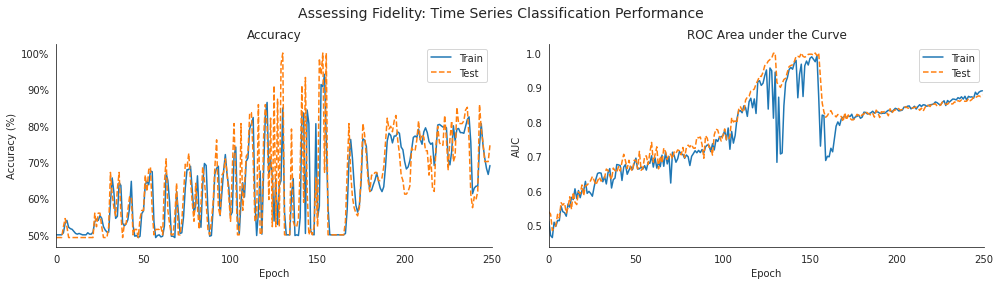

In [ ]:
sample_num = 3

sns.set_style('white')
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
history[['AUC', 'val_AUC']].rename(columns={'AUC': 'Train', 'val_AUC': 'Test'}).plot(ax=axes[1], 
                                                                                     title='ROC Area under the Curve',
                                                                                    style=['-', '--'],
                                                                                    xlim=(0, 250))
history[['accuracy', 'val_accuracy']].rename(columns={'accuracy': 'Train', 'val_accuracy': 'Test'}).plot(ax=axes[0], 
                                                                                                         title='Accuracy',
                                                                                                        style=['-', '--'],
                                                                                                        xlim=(0, 250))
for i in [0, 1]:
    axes[i].set_xlabel('Epoch')

axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
axes[0].set_ylabel('Accuracy (%)')
axes[1].set_ylabel('AUC')
sns.despine()
fig.suptitle('Assessing Fidelity: Time Series Classification Performance', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.85);
f_name = os.path.join(log_dir, "evals", "classify_sample_" + str(sample_num) + ".png")
fig.savefig(f_name)

# Train on Synthetic, test on real: Assessing usefulness

In [ ]:
real_data = get_real_data()
real_data = np.array(real_data)[:len(synthetic_data)]
real_data = np.stack(real_data, axis=0)
real_data.shape

In [132]:
real_data.shape, synthetic_data.shape

((332, 180, 4), (512, 180, 4))

In [ ]:
train_idx

In [134]:
real_train_data = real_data[train_idx, :180, :]
real_train_label = real_data[train_idx, -1, :]

real_test_data = real_data[test_idx, :180, :]
real_test_label = real_data[test_idx, -1, :]

In [135]:
real_train_data.shape, real_train_label.shape, real_test_data.shape, real_test_label.shape

((265, 180, 4), (265, 4), (67, 180, 4), (67, 4))

In [136]:
synthetic_train = synthetic_data[train_idx, :180, :]
synthetic_label = synthetic_data[train_idx, -1, :]

In [137]:
synthetic_train.shape, synthetic_label.shape

((265, 180, 4), (265, 4))

In [138]:
def get_model():
    model = Sequential([GRU(8, input_shape=(seq_len, n_seq)),
                        Dense(4)])

    model.compile(optimizer=Adam(),
                  loss='MeanAbsoluteError')
                  #(name='MAE'))
    return model

In [139]:
ts_regression = get_model()
synthetic_result = ts_regression.fit(x=synthetic_train,
                                     y=synthetic_label,
                                     validation_data=(
                                         real_test_data, 
                                         real_test_label),
                                     epochs=100,
                                     batch_size=128,
                                     verbose=0)

In [140]:
ts_regression = get_model()
real_result = ts_regression.fit(x=real_train_data,
                                y=real_train_label,
                                validation_data=(
                                    real_test_data, 
                                    real_test_label),
                                epochs=100,
                                batch_size=128,
                                verbose=0)

In [141]:
synthetic_result = pd.DataFrame(synthetic_result.history).rename(columns={'loss': 'Train', 'val_loss': 'Test'})
real_result = pd.DataFrame(real_result.history).rename(columns={'loss': 'Train', 'val_loss': 'Test'})

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-142-1dc478a2940b>", line 17, in <module>
    fig.savefig(f_name)
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/figure.py", line 2203, in savefig
    self.canvas.print_figure(fname, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/backend_bases.py", line 2126, in print_figure
    **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py", line 535, in print_png
    with cbook.open_file_cm(filename_or_obj, "wb") as fh:
  File "/usr/lib/python3.7/contextlib.py", line 112, in __enter__
    return next(self.gen)
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py", line 418, in open_file_cm
    fh, opened = to_filehandle(path_or_file, mode, True, encoding)
  File "/usr/local/lib/python3.7/d

OSError: ignored

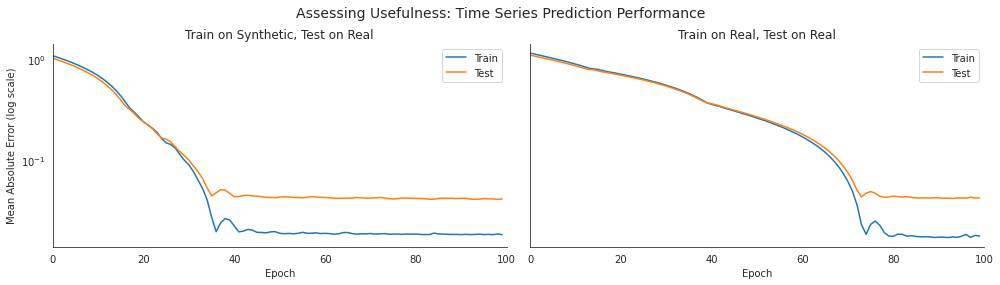

In [142]:
sample_num = 2

sns.set_style('white')

fig, axes = plt.subplots(ncols=2, figsize=(14, 4), sharey=True)
synthetic_result.plot(ax=axes[0], title='Train on Synthetic, Test on Real', logy=True, xlim=(0, 100))
real_result.plot(ax=axes[1], title='Train on Real, Test on Real', logy=True, xlim=(0, 100))
for i in [0, 1]:
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Mean Absolute Error (log scale)')

sns.despine()
fig.suptitle('Assessing Usefulness: Time Series Prediction Performance', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.85);
f_name = os.path.join(log_dir, "evals", "TSTR_sample_" + str(sample_num) + ".png")
fig.savefig(f_name)